In [3]:
from python_speech_features import mfcc
from python_speech_features import delta
from python_speech_features import logfbank
import scipy.io.wavfile as wav
import numpy as np
import pandas as pd
import os
import re
import copy
import subprocess
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline  
import matplotlib

In [36]:
(sr,y) = wav.read('test_wav/diarizationExample.wav')

In [37]:
#calculate duration of the audio
def audio_duration(y,sr):
    return len(y)/sr
#get the number of frames
def get_nFrames(y,sr,winStep=0.010 ):
    num_frames = int(len(y)/(winStep*sr)) - 1    
    return num_frames
def Sample2sec(sample, sr):
    return sample/sr
def Sec2sample(sec, sr):
    return int(sec*sr)
def Frame2sec(frame, nframes, duration):
    return (frame*duration)/nframes
def Sec2Frame(sec, nframes, duration):
    return int((sec*nframes)/duration)
def findClusterPosition(diarfile):
    cluster_idx = []
    for i in range(len(diarfile)):
        aux_line = diarfile[i]
        if len([m.start() for m in re.finditer(';;', diarfile[i])])>0:
            cluster_idx.append(i)
    nclusters = len(cluster_idx)
    return cluster_idx, nclusters
def FindSegments_Frame(diarfile, cluster_idx, nclusters):
    ClusterSegs = []
    for i in range(nclusters):
        if(i<(nclusters-1)):
            segsClus_i = diarfile[cluster_idx[i]+1:cluster_idx[i+1]]
        else:
            segsClus_i = diarfile[cluster_idx[i]+1:]
        SegsCluster_j = []
        for j in range(len(segsClus_i)):
            seg_j = segsClus_i[j]
            spaces = [m.start() for m in re.finditer(' ', seg_j)]
            fr_start = int(seg_j[(spaces[1]+1):spaces[2]])
            fr_end = int(seg_j[(spaces[2]+1):spaces[3]]) + fr_start
            SegsCluster_j.append([fr_start, fr_end])
        ClusterSegs.append(SegsCluster_j)
    return ClusterSegs
def FindSegments_Secs(Segments_Frame, nframes, duration):
    ClusterSegs = copy.deepcopy(Segments_Frame)
    for cluster_id,i in enumerate(Segments_Frame):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Frame2sec(j[0], nframes, duration)
            ClusterSegs[cluster_id][seg_id][1] = Frame2sec(j[1], nframes, duration)
    return ClusterSegs
def FindSegments_Samples(Segments_Sec, sr):
    ClusterSegs = copy.deepcopy(Segments_Sec)
    for cluster_id,i in enumerate(Segments_Sec):
        for seg_id,j in enumerate(i):
            ClusterSegs[cluster_id][seg_id][0] = Sec2sample(j[0], sr)
            ClusterSegs[cluster_id][seg_id][1] = Sec2sample(j[1], sr)
    return ClusterSegs
#function to plot 
def plot_clusteredSignal(y, Segments_Sample):
    #plt.plot(y)  
    plt.axis([0,len(y),-33000,33000])
    x = np.linspace(0,len(y), num= len(y), dtype=int)
    colors = plt.cm.tab10(np.linspace(start=0, stop=10, dtype=int, num=len(Segments_Sample)))
    for clus_idx,i in enumerate(Segments_Sample):
        for seg_idx,j in enumerate(i): 
            print(j[0], j[1])            
            plt.plot(x[j[0]:j[1]], y[j[0]:j[1]], color = colors[clus_idx])
    plt.show()
def plot_clusteredSignal_inSecs(y,sr, Segments_Sample):
    #plt.plot(y)  
    plt.axis([0,len(y)/sr,-33000,33000])
    x = np.linspace(0,len(y)/sr, num= len(y), dtype=int)
    colors = plt.cm.tab10(np.linspace(start=0, stop=10, dtype=int, num=len(Segments_Sample)))
    for clus_idx,i in enumerate(Segments_Sample):
        for seg_idx,j in enumerate(i): 
            print(j[0], j[1])            
            plt.plot(x[j[0]:j[1]], y[j[0]:j[1]], color = colors[clus_idx])
    plt.show()


In [40]:
filename = 'outFolderTeste/diarizationExample/diarizationExample.h.5.seg'
with open(filename) as f:
    diarfile = f.readlines()

In [41]:
diarfile

[';; cluster S0 \n',
 'diarizationExample 1 0 674 U U U S0\n',
 'diarizationExample 1 1108 478 U U U S0\n',
 'diarizationExample 1 1887 908 U U U S0\n',
 ';; cluster S1 \n',
 'diarizationExample 1 674 434 U U U S1\n',
 'diarizationExample 1 1586 301 U U U S1\n',
 'diarizationExample 1 2795 649 U U U S1\n',
 ';; cluster S6 \n',
 'diarizationExample 1 3444 753 U U U S6\n']

0 107875
177339 253844
302020 447349
107875 177339
253844 302020
447349 551223
551223 671744


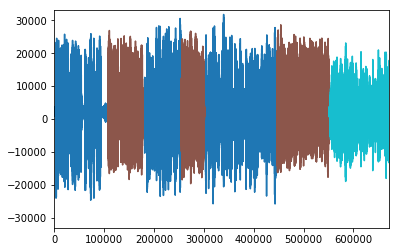

In [42]:
Segments_Frame = []
duration = audio_duration(y,sr)
nframes = get_nFrames(y,sr,winStep=0.010)
cluster_idx, nclusters = findClusterPosition(diarfile)
Segments_Frame = FindSegments_Frame(diarfile, cluster_idx, nclusters)
Segments_Sec = FindSegments_Secs(Segments_Frame, nframes, duration)
Segments_Sample = FindSegments_Samples(Segments_Sec, sr)
plot_clusteredSignal(y, Segments_Sample)

In [43]:
Segments_Frame

[[[0, 674], [1108, 1586], [1887, 2795]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[3444, 4197]]]

0 107875
177339 253844
302020 447349
107875 177339
253844 302020
447349 551223
551223 671744


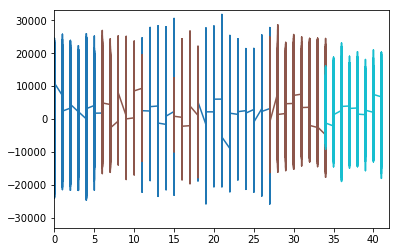

In [44]:
plot_clusteredSignal_inSecs(y,sr, Segments_Sample)

In [13]:
out_path = 'audios_segmentadosTestes/4694/'
for i in range(nclusters):
    curr_cluster = Segments_Sample[i]    
    for j in range(len(curr_cluster)):
        start = curr_cluster[j][0]
        end = curr_cluster[j][1]
        y_aux = y[start:end]
        filename = 'spk_'+str(i)+'Seg_'+str(j)+'.wav'
        wav.write(out_path+filename, sr, y_aux)
        
    

In [10]:
Segments_Sample

[[[0, 51282],
  [51282, 72323],
  [72323, 369219],
  [634513, 864126],
  [929409, 1251187],
  [1402955, 1544002],
  [1544002, 1607606],
  [1607606, 1667769],
  [1803936, 1974505],
  [1974505, 2165956],
  [2165956, 2389008]],
 [[369219, 634513],
  [864126, 929409],
  [1251187, 1402955],
  [1667769, 1728732],
  [1728732, 1803936]]]

## Visualize the feature Space

In [45]:
frame_size = 0.025
frame_stride = 0.01

In [46]:
frame_length, frame_step = frame_size * sr, frame_stride * sr
frame_length, frame_step

(400.0, 160.0)

In [47]:
signal_length = len(y)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

In [48]:
print(signal_length)
print(frame_length)
print(frame_step)
print(num_frames)

671744
400
160
4196


In [49]:
sr

16000

In [50]:
#extract mfccs
mfcc_feat = mfcc(y,sr)

In [51]:
mfcc_feat.shape

(4197, 13)

In [52]:
sr

16000

In [102]:
X= pd.DataFrame(mfcc_feat)

[[[0, 674], [1108, 1586], [1887, 2795]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[3444, 4197]]]

In [67]:
labels = np.zeros(mfcc_feat.shape[0], dtype=int)
for idx,i in enumerate(Segments_Frame):
    for j in i:
        labels[j[0]:j[1]] = idx

In [81]:
#run pca
from sklearn.preprocessing import StandardScaler

In [103]:
X= StandardScaler().fit_transform(X)

In [83]:
from sklearn.decomposition import PCA

In [84]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [93]:
finalDf = principalDf
finalDf['target'] = pd.Series(labels, index=finalDf.index)


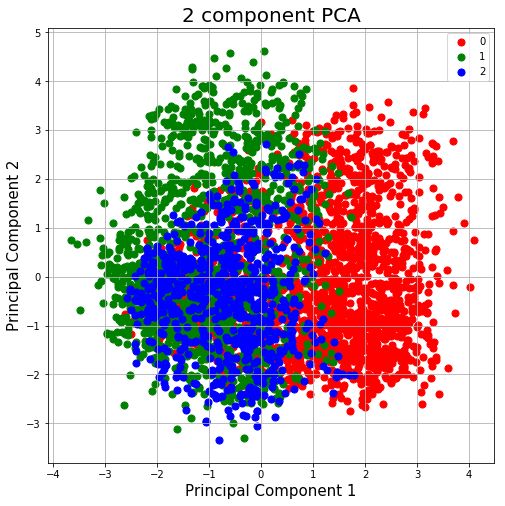

In [94]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [0,1,2]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [104]:
X = pd.DataFrame(X)
y = finalDf['target']

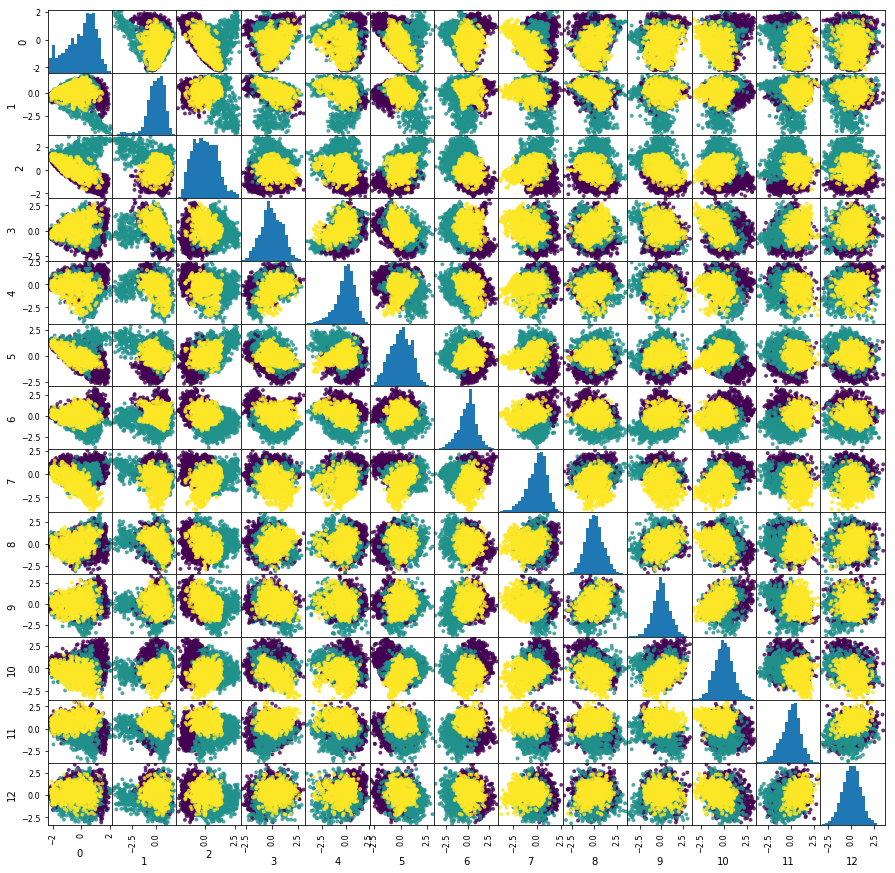

In [106]:
grr = pd.plotting.scatter_matrix(X, c=y, figsize=(15, 15), marker='.',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

In [ ]:
http://www-lium.univ-lemans.fr/diarization/doku.php/programmes

In [62]:
Segments_Frame

[[[0, 674], [1108, 1586], [1887, 2795]],
 [[674, 1108], [1586, 1887], [2795, 3444]],
 [[3444, 4197]]]

In [60]:
labels[1:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [ ]:
#teste, lendo e modificando os arquivos

input_files = 'inputfolder=./inputfolderTeste '
output_files = 'outputfolder=./outfolderTeste'




In [32]:
s = open("goTestes2.sh").read()

In [33]:
s

'inputfolder=./testaudios \noutputfolder=./out_testesaudios\n\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [35]:
start_in = 'inputfolder='
end_in = ' '

folder_wav = start_in + './inputfolderTeste'
folder_wav

'inputfolder=./inputfolderTeste'

In [38]:
pattern = re.search('%s(.*)%s' % (start_in, end_in), s).group(0)
pattern

'inputfolder=./testaudios '

In [40]:
s = s.replace(pattern, folder_wav)
s

'inputfolder=./inputfolderTeste\noutputfolder=./out_testesaudios\n\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [41]:
start_out = 'outputfolder='
end_out = '\n'

folder_out = start_out + './outFolderTeste'
folder_out

'outputfolder=./outFolderTeste'

In [42]:
pattern2 = re.search('%s(.*)%s' % (start_out, end_out), s).group(0)
pattern2

'outputfolder=./out_testesaudios\n'

In [43]:
s = s.replace(pattern2, folder_out)
s

'inputfolder=./inputfolderTeste\noutputfolder=./outFolderTeste\nmkdir -p $outputfolder\n\nfor file in $inputfolder/*.wav\ndo\n echo "Processing $file"\n ./ilp_diarization2Testes.sh $file 120 $outputfolder\ndone\n\n\n\n#why 120?\n#http://www.mickael-rouvier.fr/files/cross-show_diarization.pdf\n\n\n\n\n'

In [44]:
f = open("goTestes2.sh", 'w')
f.write(s)
f.close()

AttributeError: 'NoneType' object has no attribute 'group'

In [25]:
spaces = [m.start() for m in re.finditer(' ', s)]

In [26]:
equals = [m.start() for m in re.finditer('=', s)]

In [27]:
spaces

[24, 64, 67, 86, 91, 94, 117, 122, 134, 142, 170, 176, 180, 207]

In [28]:
equals

[11, 38]